### DATA COLLECTION

In [ ]:
# Necessary Imports
from flask import Flask, jsonify
from werkzeug.routing import IntegerConverter
from _csv import Dialect as _Dialect
import copy
import csv
import os
from lib.rtls_slave import pixel_calculate, aoa_main, sort_data
import json


ENVIRONMENT = 'random'

# Handle Negative Values
class SignedIntConverter(IntegerConverter):
    regex = r'-?\d+'
app = Flask(__name__)
app.url_map.converters['signed_int'] = SignedIntConverter
#Store input values: AoA and Horizontal Angle

aoabefore = {}
aoa= {}
lev = []

@app.route('/')
def home():
    return "This is the HomePage"

#Routing Settings
@app.route('/send/<signed_int:yaw>/<signed_int:roll>/<signed_int:pitch>', methods=['GET'])
def get_angle(yaw,roll,pitch):
    print(f"YAW: {yaw}, ROLL: {roll}, PITCH: {pitch}")
    global aoa
    global aoabefore
    
    print("Plane Angle: " + str(roll))
    aoa_result = aoa_main()
    input_letter = input("If you want to add this data to list type 'y', otherwise press Enter")
    if input_letter!='y':
        return jsonify({'state':'Try Again'})
    lev.append(roll)
    aoabefore = copy.deepcopy(aoa)
    aoa = aoa_result

    with open(f"./data/aoa_data/{ENVIRONMENT}_{roll}.json",'w') as f:
        json.dump(aoa_result, f)
        
    return jsonify({'state': 'success'})

@app.route('/calculate/', methods=['GET'])
def calculate():
    # ANGLE SORTING TECHNIQUES
    aoabefore_ = sort_data(aoabefore,aoa_bias = -35)
    aoa_ = sort_data(aoa,aoa_bias = -35)

    print("Before Turning："+str(aoabefore)+'\n'+"After Turning： " + str(aoa) +'\n'+"Rotation Angle： "+ str(lev))
    set_aoa = set(aoa_)
    set_aoabefore = set(aoabefore_)

    for slave in set_aoa.intersection(set_aoabefore):
        f = open(f"./results/pixels/{slave.replace(':','_')}.csv",'w',newline="")
        f.truncate()
        writer = csv.writer(f)
        
        data_before = aoabefore_[slave]
        data_after = aoa_[slave]

        for i in range(len(data_before[0])):
            for j in range(len(data_after[0])):
                (temp1, temp2) = pixel_calculate(lev[-2] - lev[-1], data_before[0][i], data_after[0][j])
                count = data_before[1][i]*data_after[1][j]
                if temp1 != -1:
                    tux = (temp1, temp2,count)
                    writer.writerow(tux)

        f.close()
                
        
        f.close()

    
    return jsonify({'state': 'success'})

In [ ]:
ENVIRONMENT = 'random'
app.run(host='0.0.0.0',port = 5000, debug=False)

### POST POINT CALCULATION

In [1]:
from lib.rtls_slave import post_calculation

count = 0
with open("./data/evaluation/calculation/time_analysis.txt", "r") as file:
    for line in file:
        count = count + 1
        ctnt = line.split('_')
        CASE = '_'.join(ctnt[:-2])
        L1 = int(ctnt[-2])
        L2 = int(ctnt[-1])
        print(f"CASE {count}: {CASE}")
        post_calculation(CASE,L1,L2,aoa_bias = -45,TIME = 30/30)

CASE 1: test81
Rotation Angle: 60 --> 70

Slave :80:6F:B0:EE:AD:32 
	AoA Before:[-11.42857143 -10.85714286 -10.28571429  -9.71428571  -9.14285714
  -8.57142857] 
	AoA After:[-7.85714286 -7.28571429 -6.71428571 -6.14285714 -5.57142857]
	Center: (2332.9770853246837, 1295.0592994364615)
Total Calculation time Point Cloud: 0.003000497817993164


CASE 2: test81
Rotation Angle: 65 --> 75

Slave :80:6F:B0:EE:AD:32 
	AoA Before:[-10.33333333  -9.77777778  -9.22222222  -8.66666667  -8.11111111] 
	AoA After:[-7.12903226 -6.61290323 -6.09677419 -5.58064516 -5.06451613 -4.5483871 ]
	Center: (2279.097261206599, 1282.0154372731042)
Total Calculation time Point Cloud: 0.0040013790130615234


CASE 3: test81
Rotation Angle: 70 --> 80

Slave :80:6F:B0:EE:AD:32 
	AoA Before:[-7.85714286 -7.28571429 -6.71428571 -6.14285714 -5.57142857] 
	AoA After:[-5.36363636 -4.81818182 -4.27272727 -3.72727273 -3.18181818 -2.63636364]
	Center: (2105.9870061591005, 1233.7309723445019)
Total Calculation time Point Cloud: 

f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value encountered in arccos
  azimuth_angle = np.arccos(np.cos(angle1) / np.sin(elevation_angle))
f:\intern_VisBLE\VisBLE_INTERN\codes\lib\rtls_slave.py:307: RuntimeWarning: invalid value 

### VISUALIZING THE ANGLE

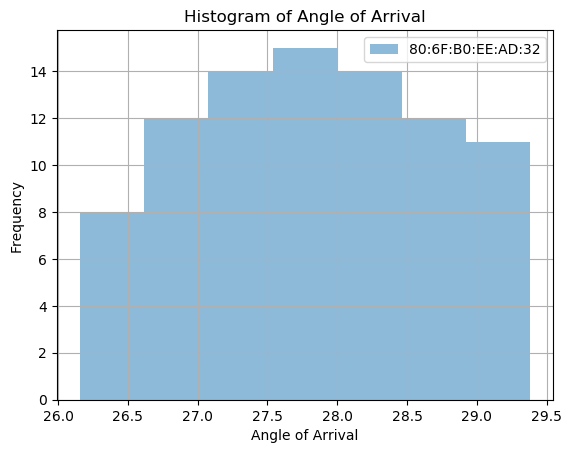

In [11]:
from lib.rtls_slave import visualize_aoa_spread

CASE = 'test99'
level = 60
visualize_aoa_spread(CASE, level)

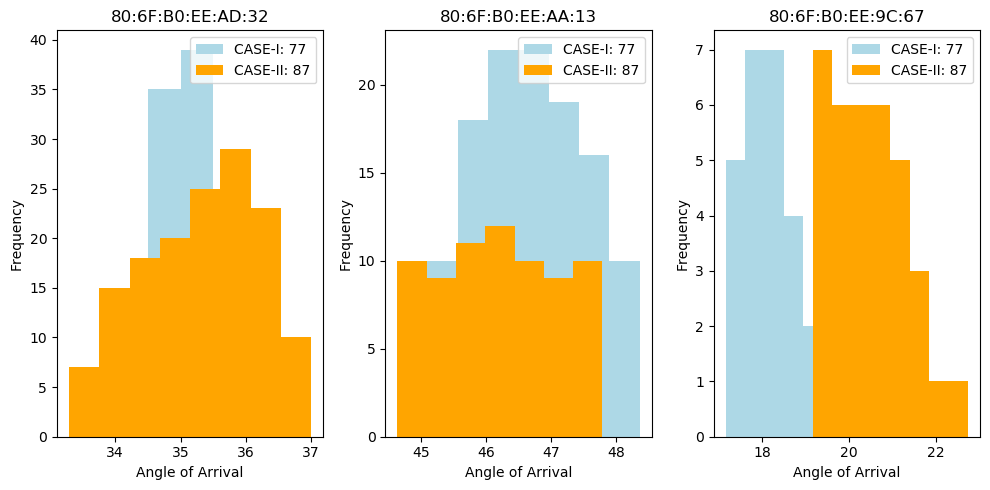

In [9]:
from lib.rtls_slave import visualize_aoa_turn_spread

CASE = 'paper'
level1 = 77
level2 = 87
vis_bias = 0

visualize_aoa_turn_spread(CASE, level1, level2, vis_bias)

### RAW DATA VISUALIZATION

In [ ]:
import matplotlib.pyplot as plt
import json

def visualize_aoa_spread(CASE, level, num_bins = 100):

    with open(f'./data/aoa_data/{CASE}_{level}.json', 'r') as f:
        aoa_data = json.load(f)

    # Create a figure and axis object
    fig, ax = plt.subplots()

    # Set the x and y labels and title
    ax.set_xlabel("Angle of Arrival")
    ax.set_ylabel("# of Occurance")
    ax.set_title("Histogram of Angle of Arrival")

    # Set the number of bins in the histogram

    # Loop over each slave and plot its angle of arrival data as a histogram
    for slave, data in aoa_data.items():
        ax.hist(data, bins=num_bins, alpha=0.5, label=slave)

    # Add a legend to the plot
    ax.legend()

    # Show the plot
    plt.show()

    if len(aoa_data.keys())>1:
        # Set up the figure with subplots
        fig, axs = plt.subplots(nrows=1, ncols=len(aoa_data.keys()), figsize=(10, 5))

        # Iterate over each slave and plot a histogram of its angle of arrival data
        for i, slave in enumerate(aoa_data.keys()):
            axs[i].hist(aoa_data[slave], bins=num_bins,color='lightblue')  # adjust bins as needed
            axs[i].set_title(slave)
            axs[i].set_xlabel("Angle of Arrival")
            axs[i].set_ylabel("# of Occurance")

        # Adjust the spacing between subplots and display the figure
        plt.tight_layout()

        plt.show()
        
        return "SUCESS"
    

visualize_aoa_spread('one_top_indoor',70,100)